# Sentiment Analysis con Redes Neuronales

## Pasos Previos

### Carga de datos en el entorno de ejecución

Antes de nada, y ya que he utilizado un Colab, tengo que crear y copiar todos los archivos que necesito, y moverlos a los directorios apropiados.

In [0]:
!mkdir data
!mkdir data/glove_word_embeddings
!mkdir datasets
!mkdir results

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/glove_word_embeddings’: File exists
mkdir: cannot create directory ‘datasets’: File exists


In [0]:
#antes de ejecutar esto tienes que subir el archivo datasets al notebook

!mv glove.6B.50d.txt data/glove_word_embeddings

mv: cannot stat 'glove.6B.50d.txt': No such file or directory


In [0]:
!mv resultados_modelos.csv results

In [0]:
!mv train_sentiment_small.csv datasets
!mv sentiment_dataset_limpio.csv datasets

mv: cannot stat 'train_sentiment_small.csv': No such file or directory
mv: cannot stat 'sentiment_dataset_limpio.csv': No such file or directory


### Imports

In [0]:
import pickle
import json
import os
import csv

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import io
from sklearn.metrics import confusion_matrix

from random import sample

from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Model
from keras.layers import Input

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
import numpy as np
from keras.layers import Conv1D, Conv2D, SimpleRNN, LSTM, Dense, Dropout
from keras.models import Sequential

In [0]:
from sklearn.model_selection import train_test_split             
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

### Variables de Entorno

In [0]:
NUM_WORDS = 5000
maxlen = 100
embedding_dim_glove = 50
embedding_layer_dim = 100
THRESHOLD = 0.5
RESULTS_FILE = 'results/resultados_modelos.csv'

### Funciones Auxiliares

Aqui defino unas funciones auxiliares para calcular metricas y presentar resultadios.

In [0]:
def add_row(df, row):
    df.loc[-1] = row
    df.index = df.index + 1  
    return df.sort_index()

In [0]:
def convertir_prediccion_en_array(prediccion):
    i = 0

    resp = []
    while i < len(prediccion):
        if prediccion[i] >= THRESHOLD:
            e = 1.0
        else:
            e = 0.0
        resp.append(e)
        i += 1
    return resp


In [0]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [0]:
def calcula_metricas(confmat, plot=True):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)

    if plot:
        plt.bar(range(5),[acc,sen,esp,ppv,fsc])
        plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
        plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
        plt.xlim((-0.5,4.5))
        plt.ylim((0,1.1))
        plt.title('Metricas')
        plt.show()
    
    metricas = [acc, sen,esp,ppv,fsc]
    return metricas

## Carga y preparación de datos

Cargo el dataset pequeño. Esto es debido a que por incompatibilidad de alguna de las capas usadas con la GPU que tiene Colab, no se puede trabajar en GPU, con lo que para entrenar en un tiempo apropiado, uso un dataset pequeño (sacado de la sección 1.1)

In [0]:
df = pd.read_csv('datasets/train_sentiment_small.csv')

# Descomentar para entrenar con el conjunto grande
#df = pd.read_csv('datasets/sentiment_dataset_limpio.csv')

In [0]:
df = df.drop(['Unnamed: 0'], axis=1)

In [0]:
df.head(5)

,Sentiment,SentimentText
0,1,<MENTION> lol ok thanks. anyway watcha doing?
1,1,"<MENTION> -- yeah, thank ya kindly!"
2,0,"<MENTION>, is being a horrible friend. tears."
3,0,Jonas Brothers 3D Concert Movie is out on the ...
4,1,<MENTION> k just call asap


In [0]:
sentiment_text = df['SentimentText'].values

In [0]:
y = df['Sentiment'].values

In [0]:
sentiment_train,sentiment_test,y_train,y_test = train_test_split(
                                                sentiment_text, y,  
                                                test_size=0.25,  
                                                random_state=42)

#Embedding

In [0]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(sentiment_train)

In [0]:
X_train = tokenizer.texts_to_sequences(sentiment_train)
X_test = tokenizer.texts_to_sequences(sentiment_test)

In [0]:
# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 

In [0]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Para generar los wordembeddings uso [Glove](https://en.wikipedia.org/wiki/GloVe_(machine_learning)), que es un conjunto preentrenado de word embeddings.

*GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.*

In [0]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [0]:
embedding_matrix = create_embedding_matrix('data/glove_word_embeddings/glove.6B.50d.txt' ,
                                            tokenizer.word_index,  
                                            embedding_dim_glove)

## Red Neuronal Convolucional

In [0]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_layer_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1155100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 1,220,529
Trainable params: 1,220,529
Non-trainable params: 0
_________________________________________________________________


Con todo el dataset se tarda un rato en entrenar (aprox 8 minutos por época), con el dataset pequeño 20s por época.

In [0]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Train on 7500 samples, validate on 2500 samples
Epoch 1/5
7500/7500 [==============================] - 18s 2ms/step - loss: 0.5937 - acc: 0.6711 - val_loss: 0.5192 - val_acc: 0.7368
Epoch 2/5
7500/7500 [==============================] - 18s 2ms/step - loss: 0.4172 - acc: 0.8124 - val_loss: 0.5445 - val_acc: 0.7352
Epoch 3/5
7500/7500 [==============================] - 18s 2ms/step - loss: 0.2511 - acc: 0.9048 - val_loss: 0.6303 - val_acc: 0.7276
Epoch 4/5
7500/7500 [==============================] - 18s 2ms/step - loss: 0.1143 - acc: 0.9621 - val_loss: 0.8165 - val_acc: 0.7168
Epoch 5/5
7500/7500 [==============================] - 18s 2ms/step - loss: 0.0504 - acc: 0.9857 - val_loss: 0.9885 - val_acc: 0.7064


In [0]:
# Evaluamos
train_acc = model.evaluate(X_train, y_train)[1]
prediction = model.predict(X_test)

7500/7500 [==============================] - 2s 324us/step


In [0]:
prediccion = convertir_prediccion_en_array(prediction)

In [0]:
confmat = confusion_matrix(y_test, prediccion)

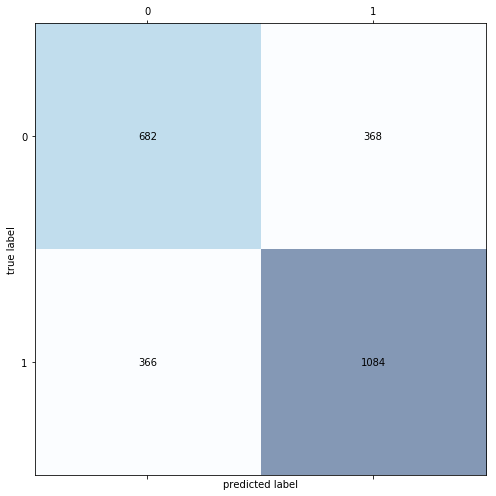

In [0]:
plot_confusion_matrix(confmat)


In [0]:
metricas = calcula_metricas(confmat, plot=False)

ACC:  0.7064
SEN:  0.7475862068965518
ESP:  0.6495238095238095
PPV:  0.7465564738292011
FSC:  0.7470709855272227


In [0]:
test_acc = metricas[0]

In [0]:
resultadosModelo = pd.read_csv(RESULTS_FILE)
resultadosModelo = resultadosModelo.drop(['Unnamed: 0'], axis=1)

In [0]:
resultado = ['CNN - Small Dataset', '-', train_acc, test_acc, confmat, metricas]

In [0]:
add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,CNN - Small Dataset,-,0.992667,0.706400,"[[682, 368], [366, 1084]]","[0.7064, 0.7475862068965518, 0.649523809523809..."
1,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
2,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
3,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
4,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
5,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."
6,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,[[ 704 602]\n [ 327 1367]],"[0.6903333333333334, 0.806965761511216, 0.5390..."
7,Decision Tree - Lemma - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.650236,0.647333,[[ 362 944]\n [ 114 1580]],"[0.6473333333333333, 0.9327036599763873, 0.277..."
8,Random Forestyes - Lemma - Small Dataset,"{'forest__max_depth': 28, 'vect__analyzer': 'c...",0.660237,0.664667,[[ 562 744]\n [ 262 1432]],"[0.6646666666666666, 0.8453364817001181, 0.430..."
9,Boosted Tree - Lemma - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.686955,0.701333,[[ 692 614]\n [ 282 1412]],"[0.7013333333333334, 0.833530106257379, 0.5298..."


In [0]:
resultadosModelo.to_csv(RESULTS_FILE)

## LSTM

In [0]:
# create the model
embedding_vecor_length = 32
model = Sequential()

model.add(layers.Embedding(vocab_size, embedding_layer_dim, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1155100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
dropout_3 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [0]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Train on 7500 samples, validate on 2500 samples
Epoch 1/3
6848/7500 [==========================>...] - ETA: 2s - loss: 7.0237 - acc: 0.5594

In [0]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_layer_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          1155100   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 1,220,529
Trainable params: 1,220,529
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1155100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 1,235,601
Trainable params: 1,235,601
Non-trainable params: 0
_____________________________________________________________

In [0]:
# Evaluamos
train_acc = model.evaluate(X_train, y_train)[1]
prediction = model.predict(X_test)

7500/7500 [==============================] - 6s 819us/step


In [0]:
prediccion = convertir_prediccion_en_array(prediction)

In [0]:
prediccion

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [0]:
dataset = []
for row in df.iterrows():
    ix, data = row
    dataset.append((data[1], data[0]))

In [0]:
from collections import Counter

In [0]:
tokens = []
tokenized = []
for x, y in dataset:
    x_t = nlp(x)
    toks = [t.text for t in x_t]
    tokens+= toks
    tokenized.append((toks, y))
    
vocab_counter = Counter(tokens)
vocab = set(tokens)
print('Num de features a usar: ', len(vocab))  
print(len(tokenized))

Num de features a usar:  16280
10000


In [0]:
maxlen = max([len(x) for x, _ in tokenized])
maxlen

179

In [0]:
lens = [len(x) for x, _ in tokenized]
median = np.median(np.array(lens))
mean = np.mean(np.array(lens))
maxlen = int(median)*2
print(median, mean, maxlen)

17.0 17.8821 34


In [0]:
tokenized_filtered = [(x, y) for x, y in tokenized if len(x) < maxlen]
len(tokenized_filtered)

9715

In [0]:
# Construir el vocabulario como siempre
w2id = {k:i for i, k in enumerate(vocab)}
w2id['<UNK>'] = len(w2id)

In [0]:
labels = ['POS', 'NEG']

In [0]:
l2id = {label:i for i, label in enumerate(labels)}

In [0]:
input_ready = []
for x, y in tokenized_filtered:
    sentence = np.zeros((maxlen))
    label = np.zeros((len(labels)))
    label[int(y)-1] = 1
    for i, t in enumerate(x):
        sentence[i] = w2id[t] if t in vocab_counter and vocab_counter[t]>=5 else w2id['<UNK>']
    input_ready.append((sentence,label))

In [0]:
input_ready[0][0].shape

(34,)

In [0]:
splits = split_train_val_test(input_ready)
print(splits['train'][0].shape)
print(splits['train'][1].shape)
splits['train'][0]

(7772, 34)
(7772, 2)


array([[ 6656.,  4920.,  7875., ...,     0.,     0.,     0.],
       [ 9182.,  9703., 14341., ...,     0.,     0.,     0.],
       [ 9182.,  9703., 14341., ...,     0.,     0.,     0.],
       ...,
       [ 9182.,  9703., 14341., ...,     0.,     0.,     0.],
       [ 9182.,  8604., 14341., ...,     0.,     0.,     0.],
       [ 9182.,  9703., 14341., ...,     0.,     0.,     0.]])

In [0]:
splits['train'][1]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [0]:
from keras.layers import Embedding
from keras.layers import Flatten, Input
from keras.models import Model

In [0]:
input_layer = Input(shape=(maxlen,) )
embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen)(input_layer)
dense_1 = Dense(300, activation='relu')(embedding)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(300, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(len(l2id), activation='softmax')(drop_2)

model = Model(inputs=input_layer, outputs=out)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 34)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 34, 100)           1628100   
_________________________________________________________________
dense_1 (Dense)              (None, 34, 300)           30300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 300)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 34, 300)           90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 34, 300)           0         
____

## 1.2.3 Deep Averaging Network

In [0]:
from keras.layers import Input, Average, average, Lambda
from keras.models import Model

from keras import backend as K

In [0]:
def mask_aware_mean(x):
    # recreate the masks - all zero rows have been masked
    mask = K.not_equal(K.sum(K.abs(x), axis=2, keepdims=True), 0)
    # number of that rows are not all zeros
    n = K.sum(K.cast(mask, 'float32'), axis=1, keepdims=False)
    # compute mask-aware mean of x
    x_mean = K.sum(x, axis=1, keepdims=False) / n
    return x_mean

def mask_aware_mean_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3
    return (shape[0], shape[2])

In [0]:
input_layer = Input(shape=(maxlen,) )
embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen)(input_layer)
doc_representation = Lambda(mask_aware_mean, mask_aware_mean_output_shape, name='embedding_average')(embedding)
dense_1 = Dense(100, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(100, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(len(l2id), activation='softmax')(drop_2)

model = Model(inputs=input_layer, outputs=out)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 34)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 34, 100)           1628100   
_________________________________________________________________
embedding_average (Lambda)   (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
____

In [0]:
input_ready = []
for x, y in tokenized_filtered:
    sentence = np.zeros((maxlen))
    label = np.zeros((len(labels)))
    label[int(y)-1] = 1
    for i, t in enumerate(x):
        sentence[i] = w2id[t] if t in vocab_counter and vocab_counter[t]>2 else w2id['<UNK>']
    input_ready.append((sentence,label))
    
splits = split_train_val_test(input_ready)
print(splits['train'][0].shape)
print(splits['train'][1].shape)

    

model.fit(splits['train'][0], splits['train'][1],
          epochs=50,
          batch_size=16)

(7772, 34)
(7772, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
7772/7772 [==============================] - 5s 700us/step - loss: 0.6522 - acc: 0.6099
Epoch 2/50
7772/7772 [==============================] - 2s 276us/step - loss: 0.5488 - acc: 0.7307
Epoch 3/50
7772/7772 [==============================] - 2s 281us/step - loss: 0.5026 - acc: 0.7608
Epoch 4/50
7772/7772 [==============================] - 2s 283us/step - loss: 0.4760 - acc: 0.7764
Epoch 5/50
7772/7772 [==============================] - 2s 291us/step - loss: 0.4600 - acc: 0.7953
Epoch 6/50
7772/7772 [==============================] - 2s 278us/step - loss: 0.4493 - acc: 0.7979
Epoch 7/50
7772/7772 [==============================] - 2s 278us/step - loss: 0.4473 - acc: 0.8037
Epoch 8/50
7772/7772 [==============================] - 2s 276us/step - loss: 0.4314 - acc: 0.8107
Epoch 9/50
7772/7772 [==============================] - 2s 282us/step - loss: 0.4265 - acc: 0

In [0]:
train_acc = model.evaluate(splits['train'][0], splits['train'][1])[1]
prediction = model.predict(splits['test'][0])

7772/7772 [==============================] - 0s 44us/step


In [0]:
prediccion = convertir_prediccion_en_array(prediction)
testeo = convertir_prediccion_en_array(splits['test'][1])

In [0]:
confmat = confusion_matrix(testeo, prediccion)

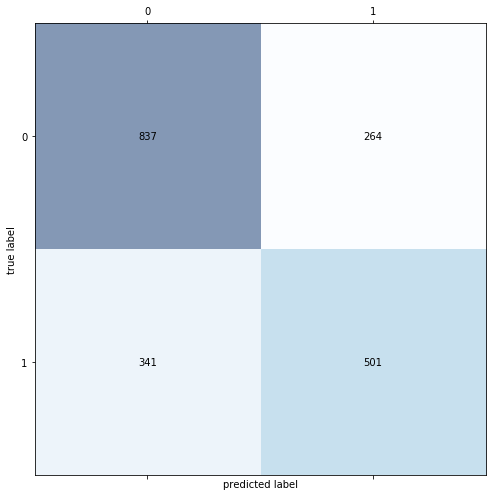

In [0]:
plot_confusion_matrix(confmat)

ACC:  0.6886258363355635
SEN:  0.5950118764845606
ESP:  0.7602179836512262
PPV:  0.6549019607843137
FSC:  0.6235220908525202


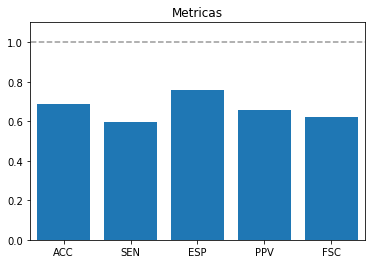

In [0]:
metricas = calcula_metricas(confmat)
test_acc = metricas[0]


In [0]:
resultadosModelo = pd.read_csv('resultados_modelos.csv')
resultadosModelo = resultadosModelo.drop(['Unnamed: 0'], axis=1)

In [0]:
resultado = ['RDN - Small Dataset', '-', train_acc, test_acc,
             confmat, metricas]

NameError: ignored

In [0]:
add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,RDN - Small Dataset,-,0.956897,0.688626,"[[837, 264], [341, 501]]","[0.6886258363355635, 0.5950118764845606, 0.760..."
1,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
2,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
3,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
4,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
5,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."
6,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,[[ 704 602]\n [ 327 1367]],"[0.6903333333333334, 0.806965761511216, 0.5390..."
7,Decision Tree - Lemma - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.650236,0.647333,[[ 362 944]\n [ 114 1580]],"[0.6473333333333333, 0.9327036599763873, 0.277..."
8,Random Forestyes - Lemma - Small Dataset,"{'forest__max_depth': 28, 'vect__analyzer': 'c...",0.660237,0.664667,[[ 562 744]\n [ 262 1432]],"[0.6646666666666666, 0.8453364817001181, 0.430..."
9,Boosted Tree - Lemma - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.686955,0.701333,[[ 692 614]\n [ 282 1412]],"[0.7013333333333334, 0.833530106257379, 0.5298..."


In [0]:
resultadosModelo.to_csv('datasets/resultados_modelos.csv')

## 1.2.3 Convolutional Neural Network

In [0]:
from keras.layers import MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Input, Embedding, Concatenate
from keras.models import Model

In [0]:
MAX_SEQUENCE_LENGTH = maxlen
EMBEDDING_DIM = embedding_dim
len(w2id)

In [0]:
embedding_layer = Embedding(len(w2id) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)

In [0]:
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

ValueError: ignored

In [0]:
embedding_dim = 100

input_layer = Input(shape=(maxlen,) )# maxlen
embedding = Embedding(output_dim=embedding_dim, input_dim=len(w2id), input_length=maxlen)(input_layer)#w2id maxlen

conv_1 = Conv1D(filters=50, kernel_size=1, strides=1, activation='relu', padding='valid')(embedding)
mp_1 = GlobalMaxPooling1D()(conv_1)

conv_2 = Conv1D(filters=50, kernel_size=2, strides=1, activation='relu', padding='valid')(embedding)
mp_2 = GlobalMaxPooling1D()(conv_2)

conv_5 = Conv1D(filters=50, kernel_size=5, strides=1, activation='relu', padding='valid')(embedding)
mp_5 = GlobalMaxPooling1D()(conv_5)

doc_representation = Concatenate()([mp_1, mp_2, mp_5])

dense_1 = Dense(100, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(100, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(len(l2id), activation='softmax')(drop_2)

model = Model(inputs=input_layer, outputs=out)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 100)      1628100     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 34, 50)       5050        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 33, 50)       10050       embed

In [0]:
print(splits['train'][0])

[[ 6656.  4920.  7875. ...     0.     0.     0.]
 [ 9182.  9703. 14341. ...     0.     0.     0.]
 [ 9182.  9703. 14341. ...     0.     0.     0.]
 ...
 [ 9182.  9703. 14341. ...     0.     0.     0.]
 [ 9182.  8604. 14341. ...     0.     0.     0.]
 [ 9182.  9703. 14341. ...     0.     0.     0.]]


In [0]:
print(splits['train'][0].shape)
print(splits['train'][1].shape)
    

model.fit(splits['train'][0], splits['train'][1],
          epochs=10,
          batch_size=16)

(7772, 34)
(7772, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
7772/7772 [==============================] - 16s 2ms/step - loss: 0.6662 - acc: 0.6020
Epoch 2/10
7772/7772 [==============================] - 14s 2ms/step - loss: 0.5886 - acc: 0.6981
Epoch 3/10
7772/7772 [==============================] - 14s 2ms/step - loss: 0.6284 - acc: 0.6971
Epoch 4/10
7772/7772 [==============================] - 15s 2ms/step - loss: 3.4518 - acc: 0.6143
Epoch 5/10
7772/7772 [==============================] - 17s 2ms/step - loss: 6.8469 - acc: 0.5704
Epoch 6/10
7772/7772 [==============================] - 15s 2ms/step - loss: 7.5071 - acc: 0.5306
Epoch 7/10
7772/7772 [==============================] - 15s 2ms/step - loss: 9.1049 - acc: 0.4349
Epoch 8/10
7772/7772 [==============================] - 13s 2ms/step - loss: 8.8911 - acc: 0.4476
Epoch 9/10
7772/7772 [==============================] - 13s 2ms/step - loss: 7.8750 - acc: 0.5094
Epo

In [0]:
train_acc = model.evaluate(splits['train'][0], splits['train'][1])[1]
prediction = model.predict(splits['test'][0])

7772/7772 [==============================] - 1s 128us/step


In [0]:
prediccion = convertir_prediccion_en_array(prediction)
testeo = convertir_prediccion_en_array(splits['test'][1])

In [0]:
confmat = confusion_matrix(testeo, prediccion)

ACC:  0.4333504889346372
SEN:  1.0
ESP:  0.0
PPV:  0.4333504889346372
FSC:  0.6046678635547577


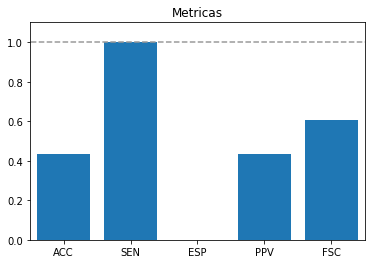

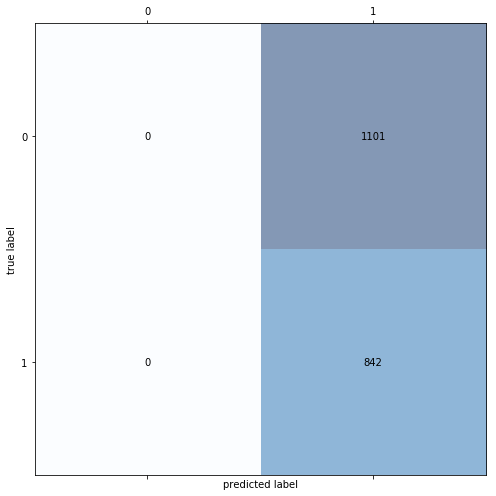

In [0]:
metricas = calcula_metricas(confmat)
test_acc = metricas[0]
plot_confusion_matrix(confmat)

In [0]:
resultado = ['CNN - Small Dataset', '-', train_acc, test_acc,
             confmat, metricas]

In [0]:
model.fit(splits['train'][0], splits['train'][1],
          epochs=50,
          batch_size=16)